# Adding a qualitative feature to a synthetic population of households


This notebook supports the paper  "A Bayesian heuristic to enrich a synthesis population by entropy optimization from aggregate data " from Pierre-Olivier Vandanjon, Boyam Fabrice Yaméogo, Pierre Hankach and Pascal Gastineau.

The core of the notebook  is to assess the Bhepop2 methodology on a real case. 

This notebook starts from a generation of synthetic households' population created for the city of Nantes. This synthetic population has an attribute, which is the number of cars owned by the household. We will refer to this population as the initial population.

We calculate the marginals for each modality of the synthetic population in the form of a percentage for this modality to have one of the modalities of the attribute "number of cars". For example, we calculate the percentage for a man to own a car. This table of marginals can be interpreted as a probability distribution, which is called  marginal distributions.

We apply the qualitative Bhepop2 algorithm with two inputs:

* The synthetic population without the attribute "number of cars owned by the household". We will call it the truncated population.
* The marginal distributions of this attribute.

The Bhepop2 algorithm will infer the truncated synthetic population with the attribute "number of cars". We will refer to the output of Bhepop2 as the reconstructed population.

We build also a naive population starting from the truncated population. For each agent of this truncated population, a modality of the attribute "number of cars" is appended according to the distribution of the modalities of the attribute " number of cars "in the initial population.

Then we compare the naive and reconstructed populations with the initial population through some metrics. 

**This code works when jupyter lab is called from the terminal, problem occurs when jupyterlab is called from the anaconda navigator**

In [1]:
import pandas as pd
import itertools

from bhepop2.functions import *


## Data preparation

Read synthetic population 



In [2]:
synt_pop = pd.read_csv("../tests/data/pop_synth_men_nantes.csv")
print(synt_pop.head())

  SFM_agg AGEREVQb_rec sexe_rec      prof Voit_rec
0     CSE         cat4    Homme  Retraite    2voit
1     CSE         cat4    Homme  Retraite    2voit
2     CSE         cat4    Homme  Retraite    2voit
3     CSE         cat4    Homme  Retraite    2voit
4     CSE         cat4    Homme  Retraite    2voit


## General parameters

In [3]:
test_seed = 42
nagents = len(synt_pop)
eps_proba = 1e-6/nagents # proba under eps_proba are considered as null
proba_min = 0.1/nagents  # we set this proba for cross modalities which are nos observed in the population, Following Laplce, if this value should be 1/nagent


## Calculation of  marginal distribution



In [4]:
def build_cross_table(pop:pd.DataFrame, names_attribute:list):
    """
    

    Parameters
    ----------
    pop : DataFrame synthesis population
    names_attribute: list of two strings
           name of attribute1 and name of attribute 2 

    Returns
    -------
    table_percentage : DataFrame
          proportion of modalities of attribute 2 given attribute 1


    """

   
    name_attribute1=names_attribute[0]
    name_attribute2=names_attribute[1]
    table_numbers=pd.crosstab(pop[name_attribute2],pop[name_attribute1]) 
    table_percentage_attribute2=table_numbers.transpose().sum()/table_numbers.transpose().sum().sum()
    table_percentage=table_numbers/table_numbers.sum()
    table_percentage['all']=table_percentage_attribute2
    table_percentage=table_percentage.transpose()
    table_percentage['modality']=table_percentage.index
    table_percentage['attribute']=name_attribute1
    
    return table_percentage



In [5]:
attributes=list(synt_pop.columns[:-1])
marginal_distribution=pd.concat(list(map(lambda a: build_cross_table(synt_pop, [a,'Voit_rec']),attributes)))
# removing multiple 'all'

marginal_distribution = marginal_distribution.loc[~marginal_distribution.index.duplicated(keep='first')]
marginal_distribution.loc["all","attribute"]="all"

print(marginal_distribution.head())

Voit_rec     0voit     1voit     2voit     3voit modality attribute
ATM       0.215885  0.401376  0.307951  0.074788      ATM   SFM_agg
CAE1      0.024035  0.243917  0.574045  0.158003     CAE1   SFM_agg
CAE2      0.014934  0.209368  0.652903  0.122794     CAE2   SFM_agg
CAE3      0.025977  0.241346  0.611276  0.121401     CAE3   SFM_agg
CSE       0.036350  0.402528  0.518663  0.042458      CSE   SFM_agg


In [6]:
print(synt_pop.head())

  SFM_agg AGEREVQb_rec sexe_rec      prof Voit_rec
0     CSE         cat4    Homme  Retraite    2voit
1     CSE         cat4    Homme  Retraite    2voit
2     CSE         cat4    Homme  Retraite    2voit
3     CSE         cat4    Homme  Retraite    2voit
4     CSE         cat4    Homme  Retraite    2voit


## Synthetic Population 




### The real distribution

In [7]:
modalities = infer_modalities_from_distributions(marginal_distribution)
modalities["Voit_rec"] = ["0voit", "1voit", "2voit", "3voit"]
test = compute_crossed_modalities_frequencies(synt_pop, modalities)
test.head()

,AGEREVQb_rec,SFM_agg,prof,sexe_rec,Voit_rec,probability
0,cat1,ATM,Agri,Homme,0voit,0.000002
1,cat1,ATM,Agri,Homme,2voit,0.000014
2,cat1,ATM,Artisans,Femme,0voit,0.000013
3,cat1,ATM,Artisans,Femme,1voit,0.000010
4,cat1,ATM,Artisans,Femme,2voit,0.000019


### The truncated populaton
the population without the feature to guess (here Voit_rec)

In [8]:
synt_pop_defected=synt_pop.copy()
synt_pop_defected = synt_pop_defected.drop(['Voit_rec'], axis=1)
print(synt_pop_defected.head())

  SFM_agg AGEREVQb_rec sexe_rec      prof
0     CSE         cat4    Homme  Retraite
1     CSE         cat4    Homme  Retraite
2     CSE         cat4    Homme  Retraite
3     CSE         cat4    Homme  Retraite
4     CSE         cat4    Homme  Retraite


## Run optimisation

Inputs : the truncated population and the marginal distribution of the feature (Voit = car)

In [9]:
from bhepop2.enrichment.bhepop2 import Bhepop2Enrichment
from bhepop2.sources.marginal_distributions import QualitativeMarginalDistributions

distributions = QualitativeMarginalDistributions(marginal_distribution, name="Source")

enrich_class = Bhepop2Enrichment(
    synt_pop_defected,
    distributions,
    feature_name="Voit_rec",
    seed=test_seed
)

# Assign data to synthetic population
bhepop2_pop = enrich_class.assign_feature_values()

print(bhepop2_pop.head())

  SFM_agg AGEREVQb_rec sexe_rec      prof Voit_rec
0     CSE         cat4    Homme  Retraite    2voit
1     CSE         cat4    Homme  Retraite    1voit
2     CSE         cat4    Homme  Retraite    2voit
3     CSE         cat4    Homme  Retraite    2voit
4     CSE         cat4    Homme  Retraite    1voit


## Resulsts analysis

### Data preparation

In [10]:
analysis = enrich_class.compare_with_source(enriched_population_name="Synthetic population")

### Some plots

In [11]:
from IPython.display import Image

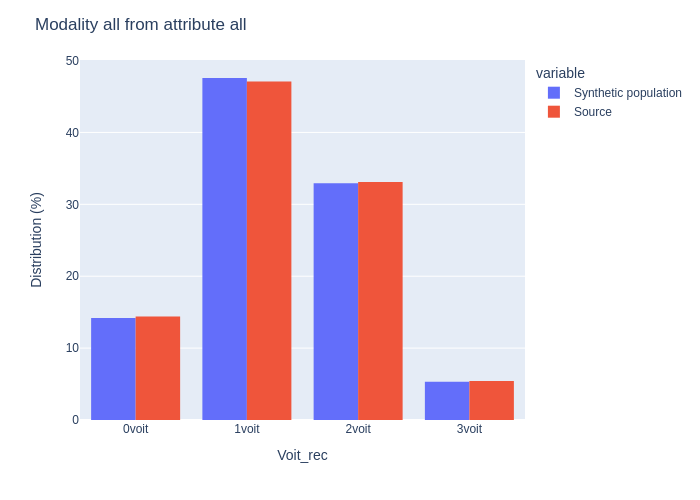

In [12]:
Image(analysis.plot_analysis_compare("all", "all").to_image())

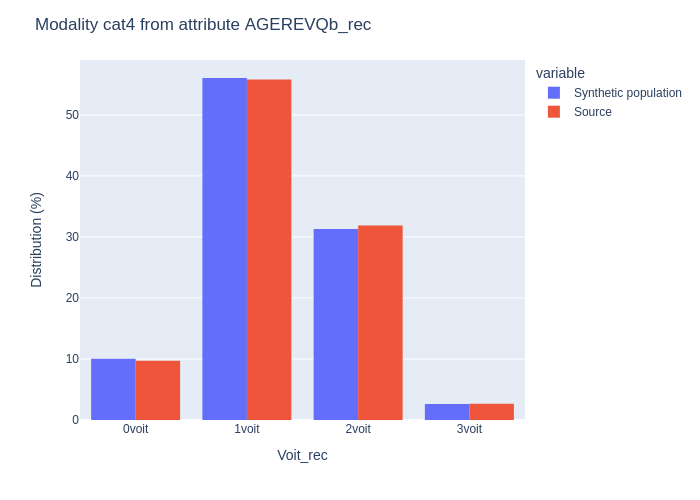

In [13]:
Image(analysis.plot_analysis_compare("AGEREVQb_rec", "cat4").to_image())

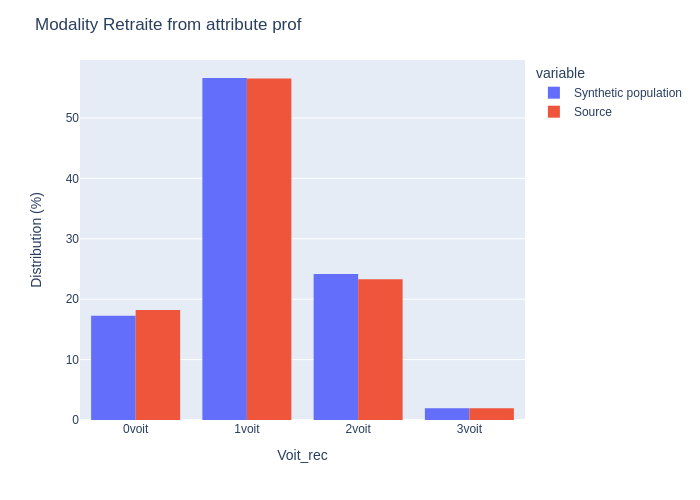

In [14]:
Image(analysis.plot_analysis_compare("prof", "Retraite").to_image())

## Computation of a common solution based on the total marginal distribution 

the bhepop2 solution will be compare with a common solution by samping according to the general frequeny of the feature in the initial population. 


In [15]:
ligne_all_voit = marginal_distribution.loc[marginal_distribution['attribute'] == 'all', '0voit':'3voit'].values
ligne_all_voit = ligne_all_voit[0] # the output of the previous line is 2D, it is downsized to 1D
common_pop=synt_pop_defected
common_pop['Voit_rec']=np.random.choice(['0voit', '1voit', '2voit', '3voit'], size=len(common_pop), p=ligne_all_voit)
print(common_pop.head())



  SFM_agg AGEREVQb_rec sexe_rec      prof Voit_rec
0     CSE         cat4    Homme  Retraite    2voit
1     CSE         cat4    Homme  Retraite    1voit
2     CSE         cat4    Homme  Retraite    1voit
3     CSE         cat4    Homme  Retraite    1voit
4     CSE         cat4    Homme  Retraite    1voit


## Metric Computation

In [16]:
def build_probability_vector(probability_df, modalities, feature_column):
    """
   Inspect the cross-modalities between the columns of the probability_df DataFrame and the modalities provided in the modalities dictionary. 
   Add the value 'feature' if the combination of modalities exists in the probability_df, otherwise add zero

    Args:
    probability_df (pd.DataFrame): DataFrame to inspect
    modalities (dict): Dictionnaire des modalités pour chaque colonne.
    feature_column (str): Nom de la colonne contenant les valeurs de feature.

    Returns:
    np.array: Vector of feature values or zero for each combination of modalities.

    Todo:
    If multiple probability values are found for the same crossed modality, it's an error.
    """
    result = []
    # Generate all possible combinations of modalities
    combinations = list(itertools.product(*modalities.values()))

    for combination in combinations:
        # Check if the combination of modalities exists in the probability_df
        mask = probability_df.apply(lambda row: all(row[colname] in [modality] for colname, modality in zip(modalities.keys(), combination)), axis=1)
        if mask.any():
        # Add the feature value if the combination of modalities exists
            result.append(probability_df.loc[mask, feature_column].values[0])
        else:
        # Add zero if the combination of modalities does not exist
            result.append(0)
    return np.array(result)




The probability distributions are computed for the tree population :
    * the initial population (in this case, the probability distribution is simply the vector frequency
    * the enriched truncated population by bhepop2
    * the enriched truncated population by a common method

In [17]:
bhepop2_prediction = compute_crossed_modalities_frequencies(bhepop2_pop, modalities)
common_prediction = compute_crossed_modalities_frequencies(common_pop, modalities)

frequencies_vector = build_probability_vector(test, modalities, 'probability')
bhepop2_probabilities_vector = build_probability_vector(bhepop2_prediction, modalities, 'probability')
common_probabilities_vector = build_probability_vector(common_prediction, modalities, 'probability')



Function that computes metrics

In [18]:
def compute_ratio(proba, freq, nagents, nmodalities, eps_proba, proba_min):
    """
    Calculates metrics between estimated probabilities and actual frequencies:
    RE: Relative Error
    R2: Coefficient of Determination
    RMSD: Root Mean Square Deviation
    MAPE: Mean Absolute Percentage Error
    Divergence: Kullback-Leibler Divergence
    Goodness of Fit:

    Args:
        proba: Vector of estimated probabilities
        freq: Vector of actual frequencies
        nmodalities: Number of crossed modalities
        eps_proba: Threshold to detect when a probability is zero
        proba_min: A detected zero probability is set to the value proba_min
        eps: If v_input(k) < eps, it is considered as zero
        proba_min: Zero probabilities are replaced by the value proba_min

    Returns:
        rmsd, mape, divergence, goodness_of_fit
    """
    def support_vector_not_null(v_input, eps, proba_min):
        """
            Builds a probability vector that does not contain zero probability. This allows for comparing probability vectors that do not have the same support.

            Args:
                v_input: Probability vector with zero components
                eps: If v_input(k) < eps, it is considered as zero
                proba_min: Zero probabilities are replaced by the value proba_min

            Returns:
                v_output: Probability vector where no component is zero

            TODO: The sum of v_output no longer equals 1... To discuss
                    No input tests.
        """
        v_output=v_input.copy()
        v_output[v_input<eps]=proba_min
        return v_output/np.sum(v_output)

    freq_not_null = support_vector_not_null(freq,eps_proba,proba_min)
    proba_not_null = support_vector_not_null(proba,eps_proba,proba_min)
    diff_vector = proba - freq
    re = np.linalg.norm(diff_vector)/np.linalg.norm(freq)
    rmsd = np.linalg.norm(diff_vector)/np.sqrt(nmodalities)
    r2 = 1-np.sum(diff_vector**2)/np.sum(freq**2)

    diff_vector = proba - freq_not_null
    mape = (np.sum(np.abs(diff_vector) / freq_not_null))/nmodalities

    divergence = np.sum( freq_not_null*np.log(freq_not_null/proba_not_null))

    diff_vector = proba_not_null - freq
    goodness_of_fit = np.sum(diff_vector**2 / proba_not_null)

    return re, r2, rmsd, mape, divergence, goodness_of_fit



### Print Metrics

In [19]:
nmodalities = len(frequencies_vector)

re, r2, rmsd, map, divergence, goodness_of_fit = compute_ratio(bhepop2_probabilities_vector, frequencies_vector, nagents, nmodalities, eps_proba, proba_min)
c_re, c_r2, c_rmsd, c_map, c_divergence, c_goodness_of_fit = compute_ratio(common_probabilities_vector, frequencies_vector, nagents, nmodalities, eps_proba, proba_min)


# Display tests results
metric_bhepop2 = [re,r2,rmsd,map,divergence,goodness_of_fit]
metric_common = [c_re,c_r2,c_rmsd,c_map,c_divergence,c_goodness_of_fit]
criteria = ['Relative Error', 'Coef of determination', 'Root Mean Square Deviation', 'Mean Absolute Percentage Error', 'Divergence', 'Goodness of fit' ]
results_test = pd.DataFrame({'Common': metric_common, 'Bhepop2': metric_bhepop2 },index=criteria)
print(results_test)


                                  Common   Bhepop2
Relative Error                  0.554545  0.152004
Coef of determination           0.692480  0.976895
Root Mean Square Deviation      0.000884  0.000242
Mean Absolute Percentage Error  7.603484  3.187330
Divergence                      0.315390  0.023665
Goodness of fit                 0.653870  0.069095


## Marginals comparisons

In [20]:
### Attribute sex

In [21]:
a='sexe_rec'
print(build_cross_table(synt_pop,[a, 'Voit_rec']))
print(build_cross_table(bhepop2_pop,[a, 'Voit_rec']))
print(build_cross_table(common_pop,[a, 'Voit_rec']))

Voit_rec     0voit     1voit     2voit     3voit modality attribute
sexe_rec                                                           
Femme     0.196093  0.521315  0.242857  0.039735    Femme  sexe_rec
Homme     0.103556  0.431649  0.399269  0.065526    Homme  sexe_rec
all       0.143884  0.470726  0.331103  0.054286      all  sexe_rec
Voit_rec     0voit     1voit     2voit     3voit modality attribute
sexe_rec                                                           
Femme     0.189136  0.524392  0.246321  0.040151    Femme  sexe_rec
Homme     0.105116  0.438177  0.393667  0.063039    Homme  sexe_rec
all       0.141733  0.475750  0.329452  0.053064      all  sexe_rec
Voit_rec     0voit     1voit     2voit     3voit modality attribute
sexe_rec                                                           
Femme     0.143549  0.471123  0.331245  0.054082    Femme  sexe_rec
Homme     0.143577  0.471064  0.331532  0.053827    Homme  sexe_rec
all       0.143565  0.471090  0.331407  0.053938

In [22]:
### Attribute Age

In [23]:
a='AGEREVQb_rec'
print(build_cross_table(synt_pop,[a, 'Voit_rec']))
print(build_cross_table(bhepop2_pop,[a, 'Voit_rec']))
print(build_cross_table(common_pop,[a, 'Voit_rec']))

Voit_rec         0voit     1voit     2voit     3voit modality     attribute
AGEREVQb_rec                                                               
cat1          0.225323  0.472254  0.274794  0.027629     cat1  AGEREVQb_rec
cat2          0.087528  0.423931  0.430097  0.058444     cat2  AGEREVQb_rec
cat3          0.082288  0.426480  0.382459  0.108773     cat3  AGEREVQb_rec
cat4          0.096897  0.557830  0.318637  0.026635     cat4  AGEREVQb_rec
cat5          0.302326  0.570125  0.120128  0.007421     cat5  AGEREVQb_rec
all           0.143884  0.470726  0.331103  0.054286      all  AGEREVQb_rec
Voit_rec         0voit     1voit     2voit     3voit modality     attribute
AGEREVQb_rec                                                               
cat1          0.222015  0.469136  0.280545  0.028304     cat1  AGEREVQb_rec
cat2          0.086933  0.424243  0.429025  0.059799     cat2  AGEREVQb_rec
cat3          0.090684  0.448257  0.359638  0.101422     cat3  AGEREVQb_rec
cat4        

In [24]:
### Attribute Familial situation

In [25]:
a='SFM_agg'
print(build_cross_table(synt_pop,[a, 'Voit_rec']))
print(build_cross_table(bhepop2_pop,[a, 'Voit_rec']))
print(build_cross_table(common_pop,[a, 'Voit_rec']))

Voit_rec     0voit     1voit     2voit     3voit modality attribute
SFM_agg                                                            
ATM       0.215885  0.401376  0.307951  0.074788      ATM   SFM_agg
CAE1      0.024035  0.243917  0.574045  0.158003     CAE1   SFM_agg
CAE2      0.014934  0.209368  0.652903  0.122794     CAE2   SFM_agg
CAE3      0.025977  0.241346  0.611276  0.121401     CAE3   SFM_agg
CSE       0.036350  0.402528  0.518663  0.042458      CSE   SFM_agg
FM        0.159056  0.641416  0.167709  0.031819       FM   SFM_agg
PS        0.300612  0.657207  0.032939  0.009241       PS   SFM_agg
all       0.143884  0.470726  0.331103  0.054286      all   SFM_agg
Voit_rec     0voit     1voit     2voit     3voit modality attribute
SFM_agg                                                            
ATM       0.220685  0.404015  0.304831  0.070469      ATM   SFM_agg
CAE1      0.025461  0.247431  0.575769  0.151339     CAE1   SFM_agg
CAE2      0.014989  0.210319  0.655452  0.119240

In [26]:
### Attribute Professionnal situation

In [27]:
a='prof'
print(build_cross_table(synt_pop,[a, 'Voit_rec']))
print(build_cross_table(bhepop2_pop,[a, 'Voit_rec']))
print(build_cross_table(common_pop,[a, 'Voit_rec']))

Voit_rec        0voit     1voit     2voit     3voit     modality attribute
prof                                                                      
Agri         0.021129  0.462416  0.426515  0.089940         Agri      prof
Artisans     0.053942  0.438695  0.419683  0.087679     Artisans      prof
Autres_inac  0.450483  0.449117  0.082886  0.017514  Autres_inac      prof
Cadres       0.063329  0.428253  0.441343  0.067076       Cadres      prof
Chom         0.583031  0.322595  0.074864  0.019510         Chom      prof
Eleve        0.575877  0.376656  0.025518  0.021950        Eleve      prof
Empl         0.131391  0.473738  0.332824  0.062046         Empl      prof
Ouvriers     0.115818  0.392833  0.404173  0.087176     Ouvriers      prof
Prof_int     0.069081  0.447609  0.414863  0.068448     Prof_int      prof
Retraite     0.182180  0.565426  0.233139  0.019256     Retraite      prof
all          0.143884  0.470726  0.331103  0.054286          all      prof
Voit_rec        0voit    

## Codes not finished to implement a global comparison as in epop2 paper

Maybe, it is useless to do this but.... 
An error to correct

In [28]:
attributes=list(bhepop2_pop.columns[:-1])
marginal_distribution_bhepop2=pd.concat(list(map(lambda a: build_cross_table(bhepop2_pop, [a,'Voit_rec']),attributes)))
# removing multiple 'all'
marginal_distribution_bhepop2 = marginal_distribution_bhepop2.loc[~marginal_distribution_bhepop2.index.duplicated(keep='first')]
marginal_distribution_bhepop2.loc["all","attribute"]="all"

print(marginal_distribution_bhepop2.head())

TypeError: 'numpy.float64' object is not callable